**Titanic Survival Prediction Using Machine Learning**


The sinking of the RMS Titanic in 1912 remains one of the most infamous maritime disasters in history, leading to significant loss of life. Over 1,500 passengers and crew perished that fateful night. Understanding the factors that contributed to survival can provide valuable insights into safety protocols and social dynamics during crises. In this project, we will leverage machine learning techniques to predict the survival chances of Titanic passengers based on various features, such as sex, age, and passenger class. Using the Random Forest classification algorithm, we aim to build a predictive model that will allow us to estimate the likelihood of survival for each individual aboard the Titanic.


For this project, we will utilize the Titanic dataset. The dataset consists of the following files:

- [train.csv](./assets/Titanic/train.csv): Contains information about the passengers and their survival status, which will be used for training our model. Serves as our primary data source for training and validation, providing both features and target labels.
- [test.csv](./assets/Titanic/test.csv): Includes details of passengers without survival labels, which we will use for making predictions. Allows us to assess the model's performance on unseen data, simulating a real-world scenario where predictions must be made for new passengers.
- [gender_submission.csv](./assets/Titanic/gender_submission.csv): A sample submission file that demonstrates the format required for submitting predictions.


Step-by-Step Implementation: Predicting Titanic Survival

## 1. Importing Libraries and Initial setup


In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
warnings.filterwarnings('ignore')

Now let's read the training and test data using the pandas data frame.


In [3]:
train = pd.read_csv('./assets/Titanic/train.csv')
test = pd.read_csv('./assets/Titanic/test.csv')

# To know number of columns and rows
train.shape
# (891, 12)

(891, 12)

To know the information about each column like the data type, etc we use the df.info() function.


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Now let's see if there are any NULL values present in the dataset. This can be checked using the isnull() function. It yields the following output.


In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## *2. Data Visualization:* Understanding Survival Trends and Passenger Demographics
   Now let us visualize the data using some pie charts and histograms to get a proper understanding of the data.

- Let us first visualize the number of survivors and death counts:


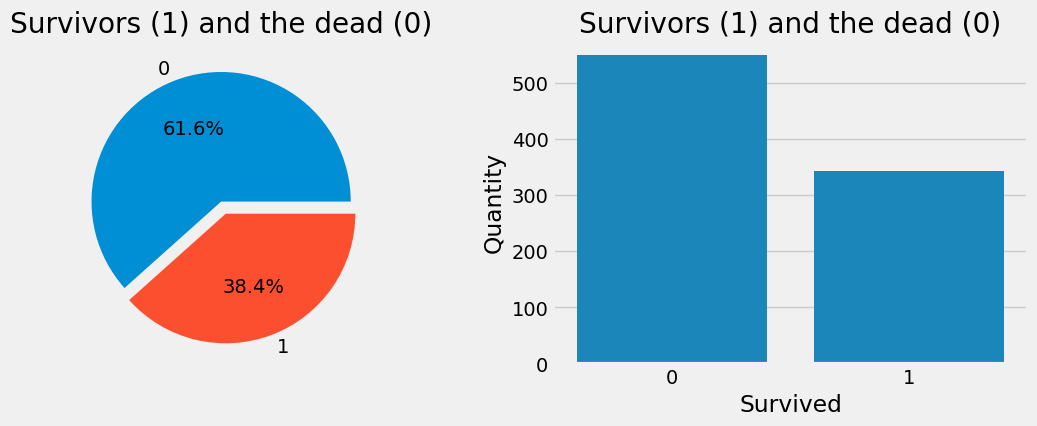

In [8]:
f, ax = plt.subplots(1, 2, figsize=(12, 4)) 
train['Survived'].value_counts().plot.pie( 
	explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=False) 
ax[0].set_title('Survivors (1) and the dead (0)') 
ax[0].set_ylabel('') 
sns.countplot(x='Survived', data=train, ax=ax[1])
ax[1].set_ylabel('Quantity') 
ax[1].set_title('Survivors (1) and the dead (0)') 
plt.show()

- Analyzing the Impact of Sex on Survival Rates: Reflects the focus on exploring how the gender of passengers influenced their chances of survival.

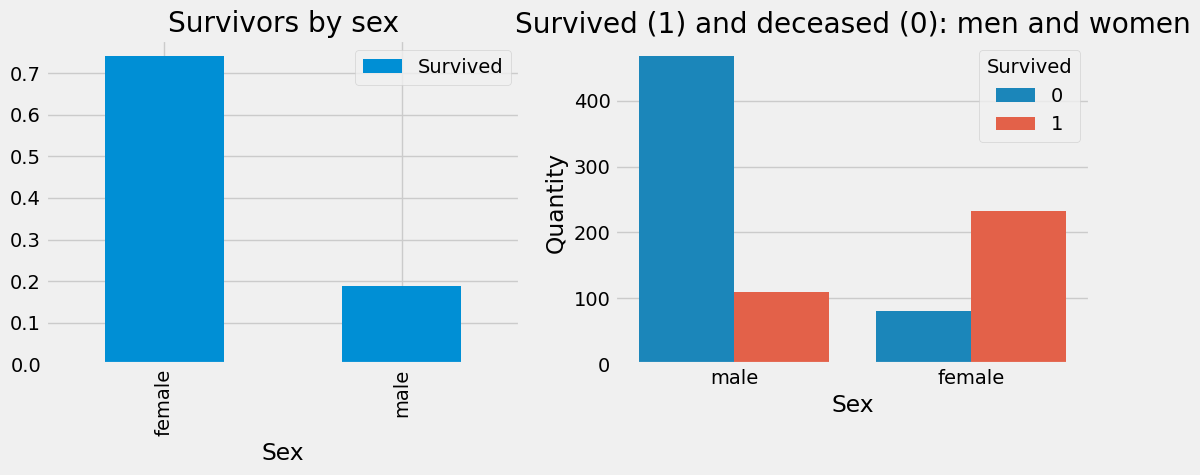

In [9]:
f, ax = plt.subplots(1, 2, figsize=(12, 4)) 
train[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0]) 
ax[0].set_title('Survivors by sex') 
sns.countplot(x='Sex', hue='Survived', data=train, ax=ax[1])
ax[1].set_ylabel('Quantity') 
ax[1].set_title('Survived (1) and deceased (0): men and women') 
plt.show()

## *3. Feature Engineering:* Optimizing Data for Model Training
This section focuses on refining the dataset by removing irrelevant features and transforming categorical data into numerical formats. Key tasks include:

- **Dropping Redundant Features:** Removing columns like Cabin that offer limited predictive value.
- **Creating New Features:** Introducing a new column to indicate whether cabin information was assigned or not.
- **Data Transformation:** Converting textual data into numerical categories for seamless model training.

In [10]:
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

We can also drop the Ticket feature since it's unlikely to yield any useful information.

In [11]:
train = train.drop(['Ticket'], axis=1)
test = test.drop(['Ticket'], axis=1)

There are missing values in the Embarked feature. For that, we will replace the NULL values with 'S' as the number of Embarks for 'S' are higher than the other two.

In [12]:
# replacing the missing values in 
# the Embarked feature with S
train = train.fillna({"Embarked": "S"})

We will now sort the age into groups. We will combine the age groups of the people and categorize them into the same groups. BY doing so we will be having fewer categories and will have a better prediction since it will be a categorical dataset.

In [13]:
# sort the ages into logical categories
train["Age"] = train["Age"].fillna(-0.5)
test["Age"] = test["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager',
          'Student', 'Young Adult', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train["Age"], bins, labels=labels)
test['AgeGroup'] = pd.cut(test["Age"], bins, labels=labels)

In the 'title' column for both the test and train set, we will categorize them into an equal number of classes. Then we will assign numerical values to the title for convenience of model training.

In [14]:
# create a combined group of both datasets
combine = [train, test]

# extract a title for each Name in the 
# train and test datasets
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

# replace various titles with more common names
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Capt', 'Col',
                                                 'Don', 'Dr', 'Major',
                                                 'Rev', 'Jonkheer', 'Dona'],
                                                'Rare')

    dataset['Title'] = dataset['Title'].replace(
        ['Countess', 'Lady', 'Sir'], 'Royal')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

# map each of the title groups to a numerical value
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3,
                 "Master": 4, "Royal": 5, "Rare": 6}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

Now using the title information we can fill in the missing age values.

In [15]:
mr_age = train[train["Title"] == 1]["AgeGroup"].mode()  # Young Adult
miss_age = train[train["Title"] == 2]["AgeGroup"].mode()  # Student
mrs_age = train[train["Title"] == 3]["AgeGroup"].mode()  # Adult
master_age = train[train["Title"] == 4]["AgeGroup"].mode()  # Baby
royal_age = train[train["Title"] == 5]["AgeGroup"].mode()  # Adult
rare_age = train[train["Title"] == 6]["AgeGroup"].mode()  # Adult

age_title_mapping = {1: "Young Adult", 2: "Student",
                     3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"}

for x in range(len(train["AgeGroup"])):
    if train["AgeGroup"][x] == "Unknown":
        train["AgeGroup"][x] = age_title_mapping[train["Title"][x]]

for x in range(len(test["AgeGroup"])):
    if test["AgeGroup"][x] == "Unknown":
        test["AgeGroup"][x] = age_title_mapping[test["Title"][x]]

Now assign a numerical value to each age category. Once we have mapped the age into different categories we do not need the age feature. Hence drop it

In [ ]:
# map each Age value to a numerical value
age_mapping = {'Baby': 1, 'Child': 2, 'Teenager': 3,
               'Student': 4, 'Young Adult': 5, 'Adult': 6, 
               'Senior': 7}
train['AgeGroup'] = train['AgeGroup'].map(age_mapping)
test['AgeGroup'] = test['AgeGroup'].map(age_mapping)

train.head()

# dropping the Age feature for now, might change
train = train.drop(['Age'], axis=1)
test = test.drop(['Age'], axis=1)

Drop the name feature since it contains no more useful information.

In [16]:
train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

Assign numerical values to sex and embarks categories

In [17]:
sex_mapping = {"male": 0, "female": 1}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)

embarked_mapping = {"S": 1, "C": 2, "Q": 3}
train['Embarked'] = train['Embarked'].map(embarked_mapping)
test['Embarked'] = test['Embarked'].map(embarked_mapping)

Fill in the missing Fare value in the test set based on the mean fare for that P-class

In [18]:
for x in range(len(test["Fare"])):
    if pd.isnull(test["Fare"][x]):
        pclass = test["Pclass"][x]  # Pclass = 3
        test["Fare"][x] = round(
            train[train["Pclass"] == pclass]["Fare"].mean(), 4)

# map Fare values into groups of 
# numerical values
train['FareBand'] = pd.qcut(train['Fare'], 4, 
                            labels=[1, 2, 3, 4])
test['FareBand'] = pd.qcut(test['Fare'], 4, 
                           labels=[1, 2, 3, 4])

# drop Fare values
train = train.drop(['Fare'], axis=1)
test = test.drop(['Fare'], axis=1)

 ## 4. Model Training: Building the Predictive Model

In this phase, we employ Random Forest as our algorithm to train the model for predicting survival. Key steps include:

- *Data Splitting:* Dividing the dataset into 80% training and 20% testing subsets using train_test_split() from the sklearn library.
- *Model Selection:* Leveraging the Random Forest algorithm, known for its robustness and ability to handle diverse data.
- *Performance Evaluation:* Assessing the trained model's accuracy on the test data to ensure it generalizes well.

In [29]:
from sklearn.model_selection import train_test_split

# Drop the Survived and PassengerId
# column from the trainset
predictors = train.drop(['Survived', 'PassengerId'], axis=1)
target = train["Survived"]
x_train, x_val, y_train, y_val = train_test_split(
    predictors, target, test_size=0.2, random_state=0)

Now import the random forest function from the ensemble module of sklearn and for the training set.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

randomforest = RandomForestClassifier()

# Fit the training data along with its output
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)

# Find the accuracy score of the model
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)

## Prediction: Generating Survival Predictions on Test Data
In this final phase, we use the trained Random Forest model to make predictions on the test dataset. The key steps are:

- Running Predictions: Input the test dataset into the trained model to predict survival outcomes.
- Preparing Results: Store the PassengerId from the test data and the corresponding Survival predictions (0 or 1).
- Saving the Output: Export the predictions to a CSV file for submission, with two columns:
    - PassengerId: ID of each passenger from the test dataset.
    - Survival: Predicted survival status (0 = Did not survive, 1 = Survived).



In [ ]:
ids = test['PassengerId']
predictions = randomforest.predict(test.drop('PassengerId', axis=1))

# set the output as a dataframe and convert 
# to csv file named resultfile.csv
output = pd.DataFrame({'PassengerId': ids, 'Survived': predictions})
output.to_csv('resultfile.csv', index=False)